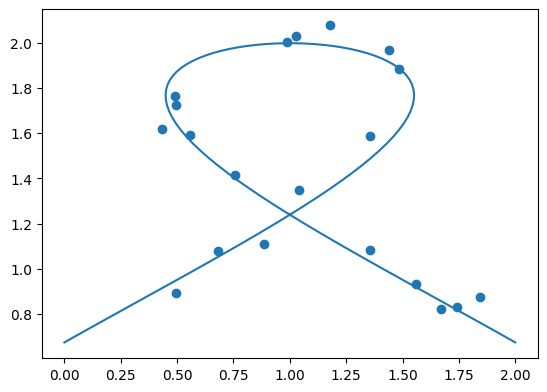

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

times = jnp.linspace(0, 1, 100)
x_positions = jnp.sin(times * 2 * jnp.pi) + 2 * times
y_positions = jnp.exp(-((0.5 + -times) ** 2)) * 6 - 4

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.plot(x_positions, y_positions, label="True trajectory")
samples = jnp.stack([x_positions, y_positions], axis=1)

n_samples = 20
samples_idx = jax.random.permutation(jax.random.PRNGKey(1), jnp.arange(100))[:n_samples]
subsampled = (
    samples[samples_idx]
    + jax.random.normal(jax.random.PRNGKey(0), (n_samples, 2)) * 0.05
)

ax.scatter(subsampled[:, 0], subsampled[:, 1], label="Subsampled observations")

In [2]:
samples_idx
# convert to mask
mask = jnp.zeros(100).astype(bool)
mask = mask.at[samples_idx].set(True)
mask = mask.at[0].set(False)
mask

Array([False, False, False, False, False, False,  True, False, False,
       False,  True,  True, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
       False, False,  True,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False,  True,  True, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True, False, False, False,  True,  True,  True,  True, False,
       False], dtype=bool)

Running q = 0
Running q = 1
Running q = 2
Running q = 3


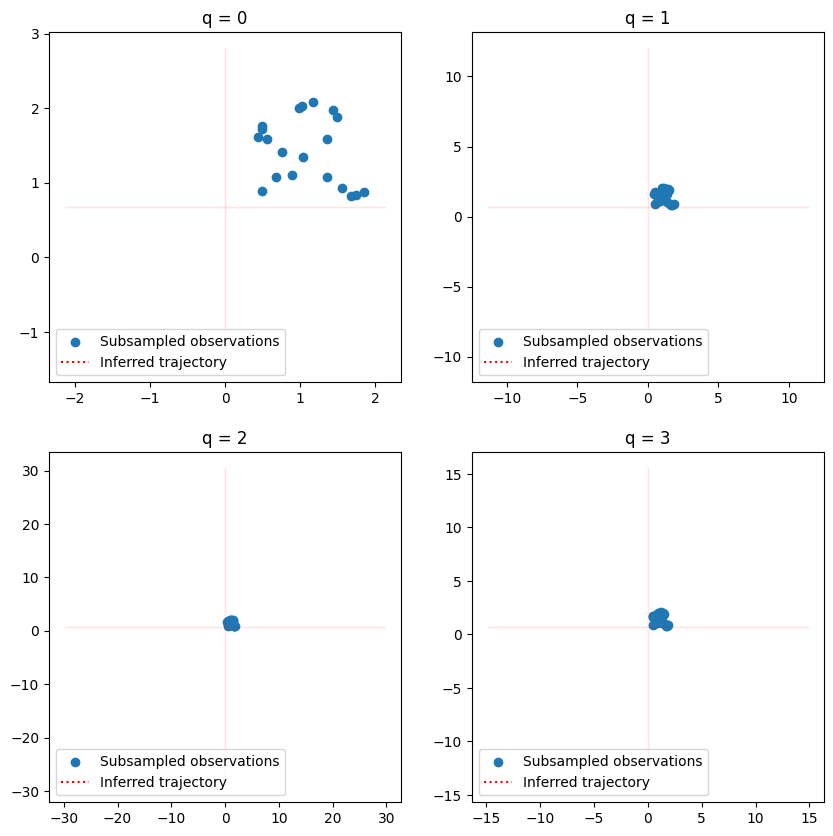

In [3]:
from app.probabilistic_numerics import kalman_filter_impl as pn


def fit_trajectory_samples(q, ax):
    state = 2
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[:2].set(samples[0])
    timesteps = 100
    delta = 1 / timesteps

    def obs(state, time, step):
        sample = samples[step]
        return state[:2] - sample

    means, stds = pn.solve_nonlinear_IVP(
        prior_dynamics=None,
        initial_mean=initial_mean,
        derivatives=q,
        timesteps=timesteps,
        delta_time=delta,
        prior="iwp",
        observation_function=obs,
        update_indicator=mask,
        observation_uncertainty=jnp.eye(state) * 0.00001,
    )
    ax.scatter(subsampled[:, 0], subsampled[:, 1], label="Subsampled observations")
    ax.plot(
        means[:, 0],
        means[:, 1],
        label="Inferred trajectory",
        linestyle="dotted",
        color="r",
    )
    ax.fill_between(
        means[:, 0],
        means[:, 1] - stds[:, 1],
        means[:, 1] + stds[:, 1],
        alpha=0.1,
        color="r",
    )
    ax.fill_betweenx(
        means[:, 1],
        means[:, 0] - stds[:, 0],
        means[:, 0] + stds[:, 0],
        alpha=0.1,
        color="r",
    )
    ax.legend()


qs = [0, 1, 2, 3]
width = int(jnp.ceil(jnp.sqrt(len(qs))))
height = int(jnp.ceil(len(qs) / width))
fig, ax = plt.subplots(height, width, figsize=(5 * width, 5 * height))
for q, ax in zip(qs, ax.flatten()):
    print(f"Running q = {q}")
    ax.set_title(f"q = {q}")
    fit_trajectory_samples(q, ax)

Running q = 2, prior = iwp, evals = 100
-0.8891902148651437
-0.8663552721459951
Running q = 2, prior = iwp, evals = 550
-0.8891902148651437
-0.6924004156370761
Running q = 2, prior = iwp, evals = 1000
-0.8891902148651437
-0.6747645991890528
Running q = 2, prior = wave, evals = 100
-0.8891902148651437
-0.8891911526253656
Running q = 2, prior = wave, evals = 550
-0.8891902148651437
-0.8488235913475342
Running q = 2, prior = wave, evals = 1000
-0.8891902148651437
-0.8444696962887592


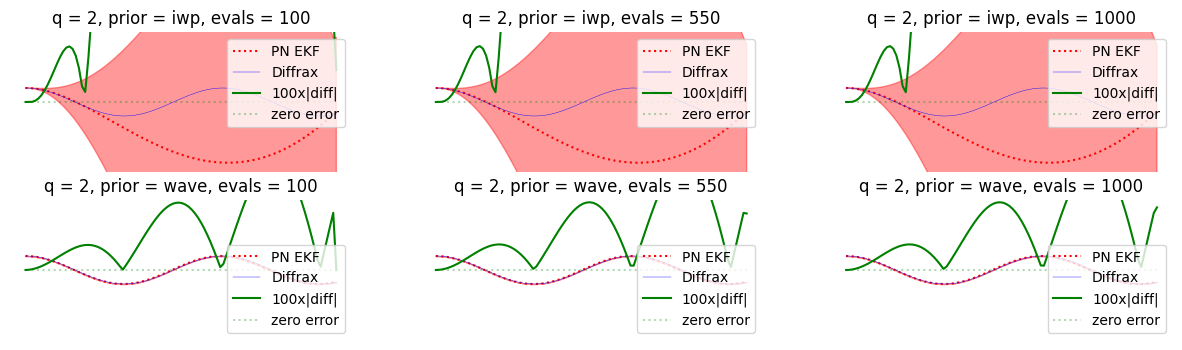

In [6]:
from app.probabilistic_numerics import kalman_filter_impl as pn
from diffrax import diffeqsolve, ODETerm, SaveAt, PIDController, Kvaerno5
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)


def vector_field(_t, state, _args):
    x, x_ = state
    return jnp.array([x_, -x])


end_time = 10
# Define the ODE term
term = ODETerm(vector_field)
solver = Kvaerno5()
saveat = SaveAt(ts=jnp.linspace(0, end_time, 100, endpoint=False))
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

# Solve the system
diffrax_sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=end_time + 0.1,
    dt0=0.01,
    y0=jnp.array([1.0, 0.0]),
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=50000,
).ys[:, 0]


def pn_solve_nonlinear_IVP(q, ax, timesteps, prior_name, prior_matrix):
    state = 1
    initial_mean = jnp.zeros(((1 + q) * state,))
    initial_mean = initial_mean.at[0].set(1.0)
    initial_mean = initial_mean.at[2].set(-1.0)

    delta = end_time / timesteps

    def zero_obs(state, time, step):
        return jnp.array([state[0] + state[2]])

    means, stds = pn.solve_nonlinear_IVP(
        prior_dynamics=prior_matrix,
        initial_mean=initial_mean,
        derivatives=q,
        timesteps=timesteps,
        delta_time=delta,
        prior=prior_name,
        observation_function=zero_obs,
        update_indicator=jnp.array([False] + [True] * (timesteps - 1)),
        observation_uncertainty=jnp.eye(1) * 0,
    )

    x_axis = jnp.linspace(0, end_time, 100)
    means = jnp.interp(
        x_axis, jnp.linspace(0, end_time, timesteps, endpoint=False), means[:, 0]
    )
    stds = jnp.interp(
        x_axis, jnp.linspace(0, end_time, timesteps, endpoint=False), stds[:, 0]
    )
    ax.plot(
        x_axis,
        means,
        label="PN EKF",
        linestyle="dotted",
        color="r",
    )
    ax.fill_between(
        x_axis,
        means - stds * 3,
        means + stds * 3,
        alpha=0.4,
        color="r",
    )
    ax.plot(
        x_axis,
        diffrax_sol,
        label="Diffrax",
        color="b",
        linewidth=0.3,
    )
    ax.plot(x_axis, 100 * jnp.abs(means - diffrax_sol), label="100x|diff|", color="g")
    ax.plot(
        x_axis, 100 * [0], label="zero error", color="g", linestyle="dotted", alpha=0.3
    )

    ax.legend()
    ax.set_ylim(-5, 5)
    ax.axis("off")

    print(diffrax_sol[-1])
    print(means[-1])

    return means, stds


qs = [2]
priors = [
    ("iwp", jnp.zeros((1, 1))),
    ("wave", -jnp.eye(1)),
]
evaluation_counts = jnp.linspace(100, 1000, 3)
import itertools

amount = len(qs) * len(priors) * len(evaluation_counts)
width = int(jnp.ceil(jnp.sqrt(amount)))
height = int(jnp.ceil(amount / width))
fig, ax = plt.subplots(height, width, figsize=(5 * width, 2 * height))

results = []

for (q, (prior_name, prior_matrix), timesteps), ax in zip(
    itertools.product(qs, priors, evaluation_counts), ax.flatten()
):
    print(f"Running q = {q}, prior = {prior_name}, evals = {int(timesteps)}")
    ax.set_title(f"q = {q}, prior = {prior_name}, evals = {int(timesteps)}")
    means, stds = pn_solve_nonlinear_IVP(
        q, ax, int(timesteps), prior_name, prior_matrix
    )
    results += [(q, prior_name, int(timesteps), means, stds)]

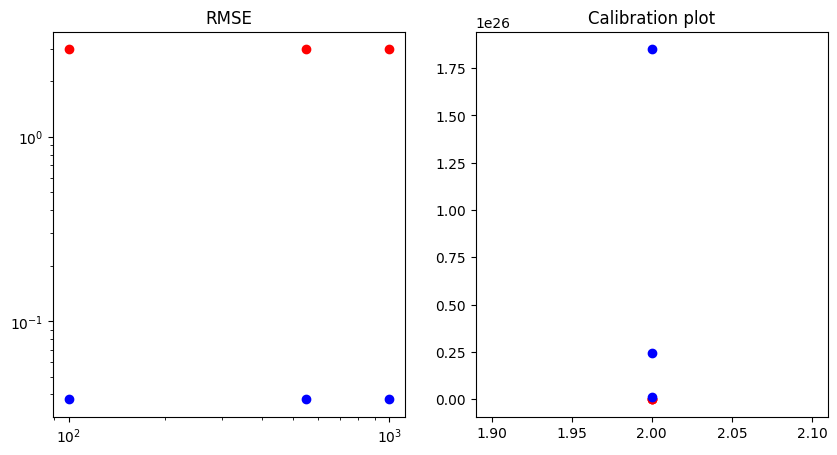

In [7]:
fig, (rmseplot, calibration_plot) = plt.subplots(1, 2, figsize=(10, 5))
rmseplot.set_title("RMSE")
rmseplot.loglog()
calibration_plot.set_title("Calibration plot")

for q, prior_name, timesteps, means, stds in results:
    rmse = jnp.sqrt(jnp.mean((means[1:] - diffrax_sol[1:]) ** 2))
    rmseplot.plot(
        timesteps,
        rmse,
        "o",
        label=f"{prior_name}",
        color="r" if prior_name == "iwp" else "b",
    )
    # rmseplot.text(timesteps, rmse, f"{prior_name} q={q}")

    calibration = jnp.mean(((means[1:] - diffrax_sol[1:]) / stds[1:]) ** 2) / 99
    calibration_plot.plot(
        q,
        calibration,
        "o",
        label=f"{prior_name}",
        color="r" if prior_name == "iwp" else "b",
    )
    # calibration_plot.text(q, calibration, f"{prior_name} q={q}")